# Stochastic Simulation Assignment 1

## Computing the Area of the Mandelbrot Set
_Authors: Sai Vinay Vardhan Daliparthi (15073815), Boyan Mihaylov (15067602), Nitai Nijholt (12709018)_

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import seaborn as sns
from scipy import stats
from scipy import constants
import os

## Mandelbrot Simulation

The following functions compute the Mandelbrot set by iterating a regular rectangular grid of complex numbers through a recursive function.

In [2]:
# creating the coordinate plane
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
wsteps, hsteps = 1000, 1000
r1 = np.linspace(xmin, xmax, wsteps)
r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
real_array, complex_array = np.meshgrid(r1,r2_imaginary)
complex_coordinate_plane = real_array + complex_array

In [3]:
def vectorized_mandlebrot(complex_coordinate_plane, max_iter, threshold):
    z = complex_coordinate_plane.copy()
    diverged_at = np.full(z.shape, max_iter)

    for n in range(max_iter):
        diverged = abs(z) > threshold
        diverged_at[diverged & (diverged_at == max_iter)] = n
        z[~diverged] = z[~diverged]**2 + complex_coordinate_plane[~diverged]

    return diverged_at

In [4]:
def calculate_mandelbrot_vectorized(xmin,xmax,ymin,ymax,wsteps,hsteps,max_iter, threshold):
    r1 = np.linspace(xmin, xmax, wsteps)
    r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
    real_array, complex_array = np.meshgrid(r1,r2_imaginary)
    complex_coordinate_plane = real_array + complex_array
    output = vectorized_mandlebrot(complex_coordinate_plane, max_iter, threshold)
    return output

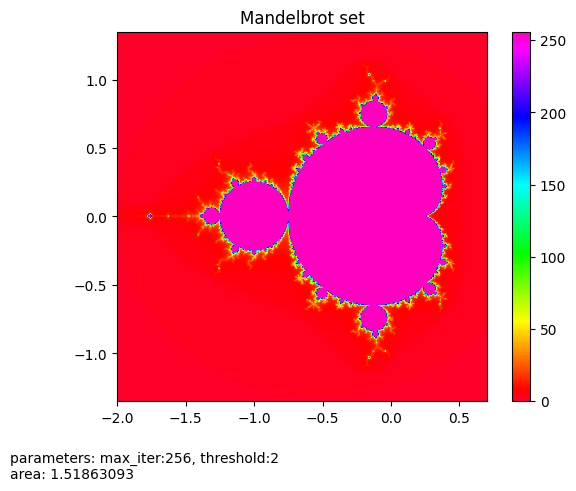

In [5]:
# xmin, xmax, ymin, ymax = -1.3, -1.05, -0.45, -0.2
# wsteps, hsteps = 1000, 1000


xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35,
wsteps, hsteps = 1000, 1000
max_iter = 256
threshold = 2


test_vectorized_mandelbrot = calculate_mandelbrot_vectorized(xmin,xmax,ymin,ymax,wsteps,hsteps,256, 2)
pt_area = (xmax - xmin) * (ymax - ymin) / (wsteps * hsteps)
area = np.sum(np.where(test_vectorized_mandelbrot == np.max(test_vectorized_mandelbrot), 1, 0)) * pt_area
plt.imshow(test_vectorized_mandelbrot, extent=(xmin, xmax, ymin, ymax), cmap='gist_rainbow')
plt.title("Mandelbrot set")
plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}\narea: {area}', horizontalalignment='left')
plt.colorbar()
plt.show()

## Approximating the Area by Pixel Counting

For a dense rectangular grid of points it is assumed that the area around the point can be calculated as:

$$
A_{pt}=\frac{1}{n_x n_y}A_R
$$

where $A_R$ is the area of the bounding region ($A_R=w\times h$) and $n_x$ and $n_y$ are the number of grid cells in $x$ and $y$ direction, respectively.

Then, to calculate the area $A_M$ of the Mandelbrot set we count the points which do not escape under the iteration function ($N_M$) and approximate the area as:

$$
A_M = N_M A_{pt}
$$

## Simulation Framework

The framework constructed below consists of the following modules:

[Sample Generator] -> [Complex Converter] -> [Mandelbrot Iterator] -> [Area Estimator] -> [Statistical Plots and Tests]

An additional procedure plots an instance of the sampling distribution tothether with the results of the Mandelbrot iteration.

### Mandelbrot Iterator

In [2]:
def mandelbrot(c, max_iter, threshold=2):
    '''Calculates the number of iterations until divergence for a given complex number c.
    Returns the number of iterations until divergence beyond threshold.'''
    z = 0
    for n in range(max_iter):
        if abs(z) > threshold:
            return n
        z = z**2 + c
    return max_iter

In [3]:
def vectorized_mandelbrot(samples_complex, max_iter, threshold=2):
    '''Calculates the number of iterations until divergence for a numpy array of complex numbers.
    Returns the number of iterations until divergence beyond threshold.'''
    z = samples_complex.copy()
    diverged_at = np.full(z.shape, max_iter)

    for n in range(max_iter):
        diverged = abs(z) > threshold
        diverged_at[diverged & (diverged_at == max_iter)] = n
        z[~diverged] = z[~diverged]**2 + samples_complex[~diverged]

    return diverged_at

In [4]:
def vectorized_mandelbrot_z(samples_complex, max_iter, threshold=2):
    '''Calculates the number of iterations until divergence for a numpy array of complex numbers.
    Returns the number of iterations until divergence beyond threshold and the iterated complex number at the last iteration.'''
    z = samples_complex.copy()
    diverged_at = np.full(z.shape, max_iter)

    for n in range(max_iter):
        diverged = abs(z) > threshold
        diverged_at[diverged & (diverged_at == max_iter)] = n
        z[~diverged] = z[~diverged]**2 + samples_complex[~diverged]

    return diverged_at, z

### Utility Functions

In [5]:
def coords_to_complex(coords_array):
    '''Takes an input array of shape (2, sample_size) containing
    the x coordinates in the first row and the y coordinates in the second.
    Converts this array to complex numbers.
    '''
    return coords_array[0] + coords_array[1]*1j

In [6]:
def get_median_divisor(number):
    '''Returns the median of all the divisors for a number.
    '''
    divisors = np.array([x for x in range(1, int(number) + 1) if number % x == 0])
    
    return divisors[int(0.5*len(divisors))]

In [7]:
def get_second_divisor(number):
    '''Returns the median of all the divisors for a number.
    '''
    divisors = np.array([x for x in range(1, int(number) + 1) if number % x == 0])
    
    return divisors[1]

### Area Estimation

In [8]:
def calc_area(xmin, xmax, ymin, ymax, iter_vals, max_iter, half=False):
    '''Estimates the area of the Mandelbrot set by counting
    the sample points which did not escape during the iteration
    and computing their fraction from the entire sample number.
    Takes the boudary region, the collection of escape times and
    the maximum reference escape time.
    '''
    
    sample_size = iter_vals.shape[0]
    in_mandelbrot = np.sum(np.where(iter_vals == max_iter, 1, 0))

    area_ratio = in_mandelbrot / sample_size
    total_area = (xmax - xmin) * (ymax - ymin)

    area = area_ratio * total_area
    
    # Double area if only half-space is sampled
    if half:
        area *= 2

    return area

### Sampling Methods

In [9]:
def grid_sampling(xmin, xmax, ymin, ymax, sample_size):
    '''Performs deterministic regular grid sampling
    '''
    samples_x = np.linspace(xmin, xmax, int(np.sqrt(sample_size)))
    samples_y = np.linspace(ymin, ymax, int(np.sqrt(sample_size)))
    samples_x_grid, samples_y_grid = np.meshgrid(samples_x, samples_y)

    return np.vstack((samples_x_grid.reshape((1, sample_size)), samples_y_grid.reshape((1, sample_size))))

In [10]:
def fibonacci_sampling(xmin, xmax, ymin, ymax, sample_size):
    '''Creates a regular concentric sampling using a fibonacci spiral.
    the resulting samples are less than the input size due to
    truncation with the rectangular region
    '''

    radius = np.sqrt(max(abs(xmin), abs(xmax))**2 + max(abs(ymin), abs(ymax))**2)/np.sqrt(sample_size)
    ts = np.arange(0, sample_size, 1)
    samples_x = radius*np.sqrt(ts)*np.cos(ts*2*np.pi/constants.golden)
    samples_y = radius*np.sqrt(ts)*np.sin(ts*2*np.pi/constants.golden)

    sample_pts = np.vstack((samples_x, samples_y)).T

    sample_pts_culled = [sp for sp in sample_pts if xmin < sp[0] < xmax and ymin < sp[1] < ymax]

    sample_pts_culled = np.array(sample_pts_culled).T
    
    return sample_pts_culled

In [11]:
def pure_random_sampling(xmin, xmax, ymin, ymax, sample_size, seed=None):
    '''Performs pure uniform random sampling over the given interval.
    '''
    
    if seed is not None:
        np.random.seed(seed)
    
    return np.random.uniform((xmin, ymin), (xmax, ymax), size=(sample_size, 2)).T

In [12]:
def latin_hypercube_sampling(xmin, xmax, ymin, ymax, sample_size, seed=None):
    '''Performs latin hypercube sampling over the given interval.
    '''

    if seed is not None:
        np.random.seed(seed)

    # creating a list of x and y coordinates from the xmin, xmax, ymin, ymax
    # note that stepsize = samplesize, so that the number of samples is equal to the number of steps. This is a requirement for LHS, see: https://en.wikipedia.org/wiki/Latin_hypercube_sampling
    x_base = np.linspace(xmin, xmax, sample_size + 1)[:-1]
    y_base = np.linspace(ymin, ymax, sample_size + 1)[:-1]

    # permutations of x and y are made to ensure that LHS requirements are met
    x_base = np.random.permutation(x_base)
    y_base = np.random.permutation(y_base)

    # adding a random value to the base grid
    x_coords = x_base + np.random.uniform(0, (xmax - xmin)/sample_size, size=x_base.shape)
    y_coords = y_base + np.random.uniform(0, (ymax - ymin)/sample_size, size=y_base.shape)
    
    return np.vstack([x_coords, y_coords])

In [13]:
def orthogonal_sampling(xmin, xmax, ymin, ymax, sample_size, n_sub_intervals, seed=None):
    '''Performs orthogonal sampling over the given interval.
    n_sub_intervals indicates the number of subdivisions per dimension inside a cell of the supergrid.
    '''

    n_intervals = int(np.sqrt(sample_size))
    
    # Guarantee that interval is a power of two and is divisible by number of subintervals
    if n_intervals%n_sub_intervals != 0:
        print("Mismatched grid parameters!")
        return None

    n_intervals = int(n_intervals)

    if seed is not None:
        np.random.seed(seed)
    
    # base coordinates for large grid cells
    x_base = np.linspace(xmin, xmax, n_intervals + 1)[:-1]
    y_base = np.linspace(ymin, ymax, n_intervals + 1)[:-1]

    x_grid_base, y_grid_base = np.meshgrid(x_base, y_base)

    x_grid_base = x_grid_base.flatten()
    y_grid_base = y_grid_base.flatten()

    # base coordinates for fine grid cells
    x_interval = (xmax - xmin) / n_intervals
    y_interval = (ymax - ymin) / n_intervals
    x_base_sub = np.linspace(0, x_interval, n_sub_intervals+1)[:-1]
    y_base_sub = np.linspace(0, y_interval, n_sub_intervals+1)[:-1]

    # permutations of x and y are made to ensure that LHS requirements are met
    x_base_sub_permutations = np.array([np.random.permutation(x_base_sub) for _ in range(sample_size//n_sub_intervals)])
    y_base_sub_permutations = np.array([np.random.permutation(y_base_sub) for _ in range(sample_size//n_sub_intervals)])

    # permute the permuted intervals so they mix between columns as well
    x_base_sub_permutations = x_base_sub_permutations.flatten()
    y_base_sub_permutations = y_base_sub_permutations.flatten()
    x_base_sub_permutations = np.random.permutation(x_base_sub_permutations)
    y_base_sub_permutations = np.random.permutation(y_base_sub_permutations)

    # adding large grid coordinates + permuted fine grid coordinates + random component
    x_coords = x_grid_base + x_base_sub_permutations + np.random.uniform(0, x_interval/n_sub_intervals, size=x_grid_base.shape)
    y_coords = y_grid_base + y_base_sub_permutations + np.random.uniform(0, y_interval/n_sub_intervals, size=y_grid_base.shape)

    return np.vstack([x_coords, y_coords])

### Plotting Method

In [14]:
def plot_samples_mandelbrot(xmin, xmax, ymin, ymax, samples, iter_vals, half=False, ax=None, **params):
    '''Plots the sampling distribution, indicating the relationship to the Mandelbrot set.
    The input **params takes the parameters used for the simulation
    '''

    if half: cb_shrink = 0.5
    else: cb_shrink = 1.0
    
    modify_fig = False
    if not ax:
        fig, ax = plt.subplots()
        fig.set_size_inches(6, 3*cb_shrink+2)
        modify_fig = True

    # plot grid for stratified methods
    if params['sampling_method'] == 'LHS' and samples.shape[0] <= 100:
        ax.set_xticks(np.linspace(xmin, xmax, samples.shape[0]+1), minor=True)
        ax.set_yticks(np.linspace(ymin, ymax, samples.shape[0]+1), minor=True)
        ax.grid(which='minor')
    if params['sampling_method'] == 'Orthogonal Sampling' and samples.shape[0] <= 100:
        ax.set_xticks(np.linspace(xmin, xmax, samples.shape[0]//params['sub_lvl'] + 1), minor=False)
        ax.set_yticks(np.linspace(ymin, ymax, samples.shape[0]//params['sub_lvl'] + 1), minor=False)
        ax.set_xticks(np.linspace(xmin, xmax, samples.shape[0]+1), minor=True)
        ax.set_yticks(np.linspace(ymin, ymax, samples.shape[0]+1), minor=True)
        ax.grid(which='both')
    
    scat = ax.scatter(samples.real, samples.imag, c=iter_vals, s=1000/samples.shape[0])
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    ax.set_aspect('equal')

    if modify_fig:
        fig.suptitle(f"Mandelbrot set: {params['sampling_method']}")
        fig.text(0.1,-0.05,f"Parameters: max_iter: {params['max_iter']}, threshold: {params['threshold']}\narea: {params['area']}", horizontalalignment='left')
        fig.colorbar(scat, label='escape iterations', ax=ax, shrink=cb_shrink)

        plt.tight_layout()
        plt.show()
    
    return scat

### Parameter Exploration

In [15]:
def parameter_exploration(xmin, xmax, ymin, ymax, sample_range, iter_range, num_runs, sampling_type, seed_range=None, half=False):
    '''Performs multiple simulations with different parameter combinations provided
    by the arrays sample_range and iter_range. If seed_range is not provided,
    consecutive seeds starting from zero are taken.
    Outputs a DataFrame containing the area estimation results.
    '''

    sim_table = np.empty((len(iter_range)*len(sample_range)*num_runs, 4))
    seed_ct = 0
    for i, iteration in enumerate(iter_range):
        for j, sample_size in enumerate(sample_range):
            for k in range(num_runs):
                if seed_range:
                    seed = seed_range[seed_ct]
                else:
                    seed = seed_ct
                
                # Determine sampling function
                match sampling_type:
                    case 'random': pt_samples = pure_random_sampling(xmin, xmax, ymin, ymax, sample_size, seed=seed)
                    case 'LHS': pt_samples = latin_hypercube_sampling(xmin, xmax, ymin, ymax, sample_size, seed=seed)
                    case 'ortho': pt_samples = orthogonal_sampling(xmin, xmax, ymin, ymax, sample_size, n_sub_intervals=get_median_divisor(np.sqrt(sample_size)), seed=seed)
                    case _: print("Invalid sampling function")
                
                complex_samples = coords_to_complex(pt_samples)
                mandelbrot_iters = vectorized_mandelbrot(complex_samples, iteration)
                area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, iteration, half)

                index = (i*len(sample_range) + j)*num_runs + k
                sim_table[index] = np.array([k, iteration, sample_size, area])

                seed_ct += 1
    
    df_simulations = pd.DataFrame(sim_table, columns=['Simulation', 'Iterations', 'Samples', 'Area'])
    df_simulations.insert(0, 'Strategy', np.full(df_simulations.shape[0], sampling_type))
    mean_final = df_simulations[(df_simulations['Iterations'] == iter_range[-1]) & (df_simulations['Samples'] == sample_range[-1])]['Area'].mean()
    df_simulations.insert(5, 'Error', df_simulations['Area'].to_numpy() - np.full(df_simulations.shape[0], mean_final))

    return df_simulations

## Simulations

### Mandelbrot Set Exploration

The procedure below explores details in different regions of the Mandelbrot set.

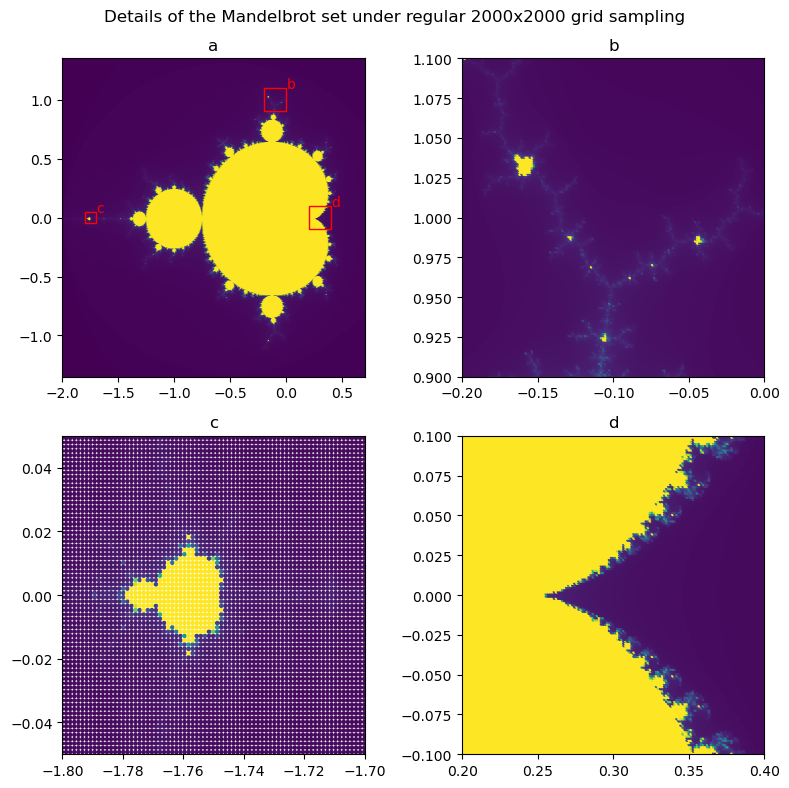

In [16]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 4000000
max_iter = 256

zoom_regions = [[[xmin, xmax], [ymin, ymax]],
                [[-0.2, 0], [0.9, 1.1]],
                [[-1.8, -1.7], [-0.05, 0.05]],
                [[0.2, 0.4], [-0.1, 0.1]]]

pt_samples = grid_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
mandelbrot_iters = mandelbrot_iters.reshape((int(np.sqrt(sample_size)), int(np.sqrt(sample_size))))

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)
fig.suptitle("Details of the Mandelbrot set under regular 2000x2000 grid sampling")
for i in range(len(zoom_regions)):
    zxmin = zoom_regions[i][0][0]
    zxmax = zoom_regions[i][0][1]
    zymin = zoom_regions[i][1][0]
    zymax = zoom_regions[i][1][1]
    msize = 0.5/min([zoom_regions[i][0][1]-zoom_regions[i][0][0], zoom_regions[i][1][1]-zoom_regions[i][1][0]])
    axs[int(np.floor(i/2))][i%2].scatter(pt_samples[0], pt_samples[1], c=mandelbrot_iters, s=msize)
    axs[int(np.floor(i/2))][i%2].set_xlim((zxmin, zxmax))
    axs[int(np.floor(i/2))][i%2].set_ylim((zymin, zymax))
    axs[int(np.floor(i/2))][i%2].set_title('abcd'[i])
    if i == 0:
        for j, zr in enumerate(zoom_regions):
            if i!=j:
                axs[int(np.floor(i/2))][i%2].add_patch(mp.Rectangle((zr[0][0], zr[1][0]), zr[0][1]-zr[0][0], zr[1][1]-zr[1][0], edgecolor='red', facecolor='none', lw=1))
                axs[int(np.floor(i/2))][i%2].annotate('abcd'[j], (zr[0][1], zr[1][1]), c='red')
    # axs[int(np.floor(i/2))][i%2].set_aspect('equal')

plt.tight_layout()

### Mandelbrot Set Sampling

A quasi-ground-truth value for the area estimation can be obtained by the brute-force approach of sampling a dense uniform grid that sets a maximum boundary for the number of samples used in the subsequent stochastic experiments.

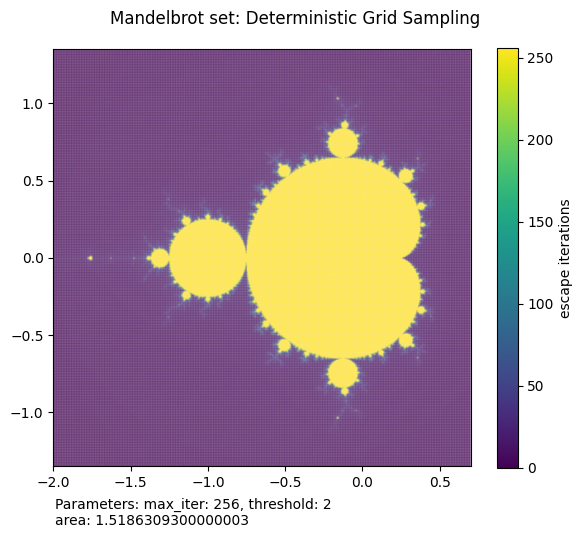

In [21]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 1000000
max_iter = 256

# brute-force deterministic grid sampling
pt_samples = grid_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, max_iter)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters,
                        sampling_method='Deterministic Grid Sampling', max_iter=max_iter, threshold=2, area=area)

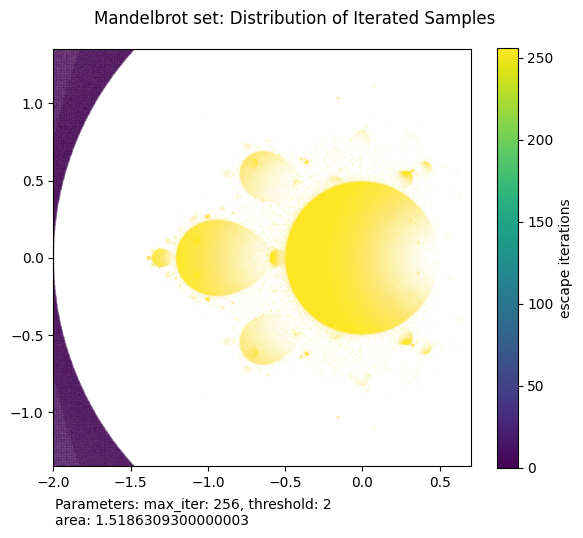

In [22]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 1000000 # run with 100000000 when at home
max_iter = 256

# brute-force deterministic grid sampling
pt_samples = grid_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters, zs = vectorized_mandelbrot_z(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, max_iter)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, zs, mandelbrot_iters,
                        sampling_method='Distribution of Iterated Samples', max_iter=max_iter, threshold=2, area=area)

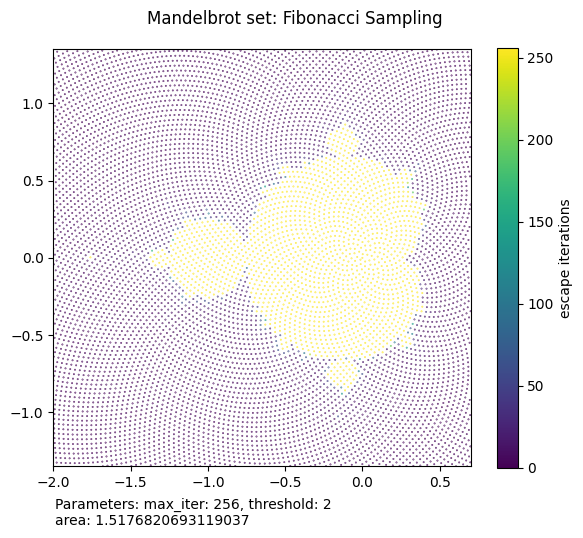

In [23]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 20000
max_iter = 256

# deterministic fibonacci spiral sampling
pt_samples = fibonacci_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, max_iter)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters,
                        sampling_method='Fibonacci Sampling', max_iter=max_iter, threshold=2, area=area)

The following procedure tests the three sampling types using a single simulation per type.

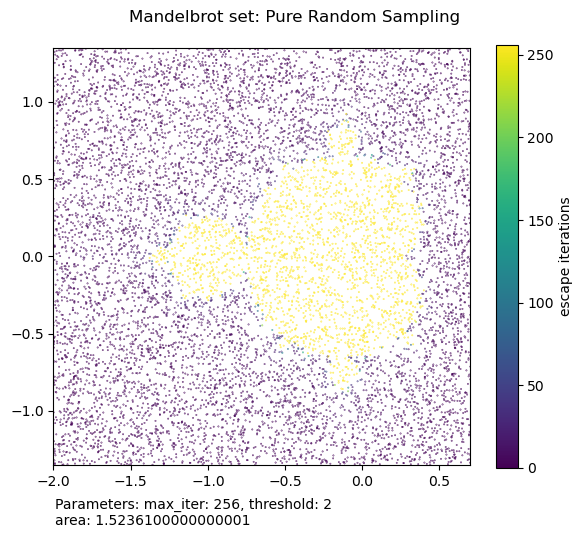

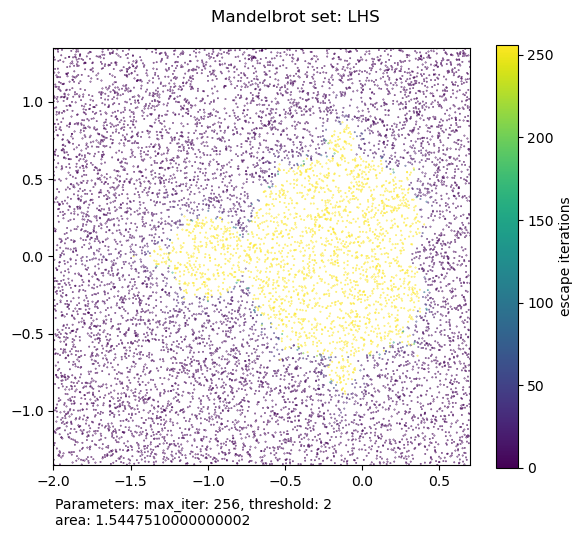

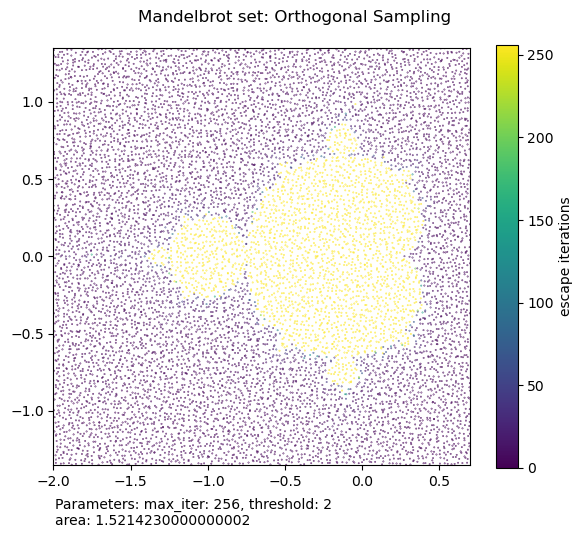

In [53]:
half = False

if half: xmin, xmax, ymin, ymax = -2.0, 0.7, 0, 1.35
else: xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 10000
max_iter = 256

# test pure random sampling
pt_samples = pure_random_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, max_iter, half=half)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters, half=half,
                        sampling_method='Pure Random Sampling', max_iter=max_iter, threshold=2, area=area)

# test LHS
pt_samples = latin_hypercube_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, max_iter, half=half)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters, half=half,
                        sampling_method='LHS', max_iter=max_iter, threshold=2, area=area)

# test orthogonal sampling
pt_samples = orthogonal_sampling(xmin, xmax, ymin, ymax, sample_size, 10)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, max_iter, half=half)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters, half=half,
                        sampling_method='Orthogonal Sampling', max_iter=max_iter, threshold=2, sub_lvl=10, area=area)

As the Mandelbrot set is symmetrical along the real number axis, it is sufficient to sample only half the complex plane to get an estimate of half of the area.

C:\Users\nitai\AppData\Local\Temp\ipykernel_36920\3678400033.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


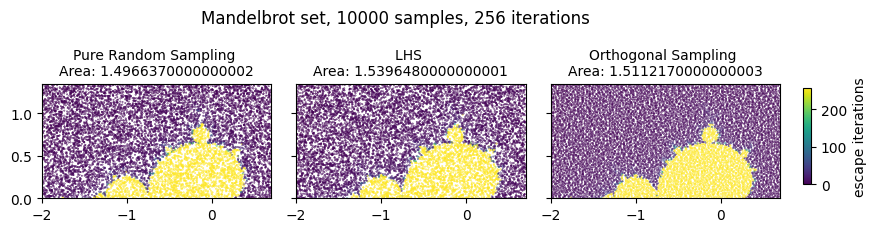

In [25]:
half = True

if half: xmin, xmax, ymin, ymax = -2.0, 0.7, 0, 1.35
else: xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 10000
max_iter = 256

fig, axs = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(8, 2.4)

# test pure random sampling
pt_samples = pure_random_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, max_iter, half=half)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters, half=half, ax=axs[0],
                        sampling_method='Pure Random Sampling', max_iter=max_iter, threshold=2, area=area)
axs[0].set_xlim((xmin, xmax))
axs[0].set_ylim((ymin, ymax))
axs[0].set_aspect('equal')
axs[0].set_title(f"Pure Random Sampling \nArea: {area}", fontsize='medium')

# test LHS
pt_samples = latin_hypercube_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, max_iter, half=half)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters, half=half, ax=axs[1],
                        sampling_method='LHS', max_iter=max_iter, threshold=2, area=area)
axs[1].set_xlim((xmin, xmax))
axs[1].set_ylim((ymin, ymax))
axs[1].set_aspect('equal')
axs[1].set_title(f"LHS \nArea: {area}", fontsize='medium')

# test orthogonal sampling
pt_samples = orthogonal_sampling(xmin, xmax, ymin, ymax, sample_size, 10)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, max_iter, half=half)
scat = plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters, half=half, ax=axs[2],
                        sampling_method='Orthogonal Sampling', max_iter=max_iter, threshold=2, sub_lvl=10, area=area)
axs[2].set_xlim((xmin, xmax))
axs[2].set_ylim((ymin, ymax))
axs[2].set_aspect('equal')
axs[2].set_title(f"Orthogonal Sampling \nArea: {area}", fontsize='medium')

cbar_ax = fig.add_axes([1.01, 0.25, 0.01, 0.4])
fig.suptitle(f"Mandelbrot set, {sample_size} samples, {max_iter} iterations")
fig.colorbar(scat, label='escape iterations', cax=cbar_ax)

plt.tight_layout()
plt.show()

### Parameter Exploration

The next procedure runs 1000 simulations per parameter configuration (sample size, iterations) and plots the statistics for all different sampling strategies.

In [26]:
# xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
xmin, xmax, ymin, ymax = -2.0, 0.7, 0, 1.35 # takes only positive Im(c) region
sample_range = np.array([x for x in np.arange(10, 100, 1, dtype=int) if get_median_divisor(x) not in (1, x)])**2 # avoid prime numbers
# iter_range = np.power(2, np.arange(1, 11, 1), dtype=int)
iter_range = np.arange(10, 1001, 90)
num_runs = 1000

sampling_types = ['random', 'LHS', 'ortho']

df_area_strategies = []

for sampling_type in sampling_types:
    df_area_strategies.append(parameter_exploration(xmin, xmax, ymin, ymax, sample_range, iter_range, num_runs, sampling_type=sampling_type, half=True))

df_area = pd.concat(df_area_strategies)

# Save DataFrame to .csv
df_area.to_csv(f"area_data_{num_runs}_runs.csv")    

KeyboardInterrupt: 

The data from a previous execution can be read through the following procedure.

In [27]:
sample_range = np.array([x for x in np.arange(10, 100, 1, dtype=int) if get_median_divisor(x) not in (1, x)])**2 # avoid prime numbers
# iter_range = np.power(2, np.arange(1, 11, 1), dtype=int)
iter_range = np.arange(2, 1000)
num_runs = 1000

df_area = pd.read_csv(f"area_data_{num_runs}_runs.csv")
print(pd.unique(df_area['Simulation']).shape)
df_area

FileNotFoundError: [Errno 2] No such file or directory: 'area_data_1000_runs.csv'

### Statistical Results

The results from the series of simulations are visualised in a multiple plots.

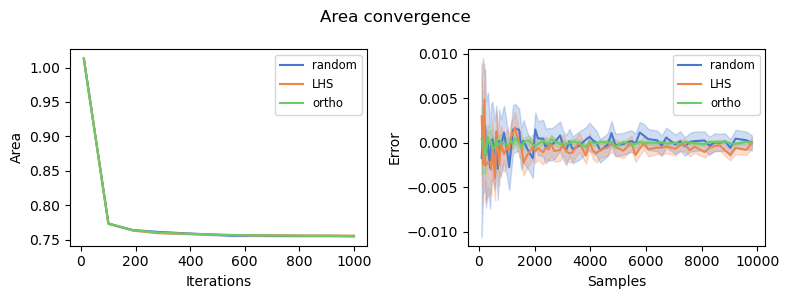

In [ ]:
# errorbar = ('sd', 1)
errorbar = ('ci', 95)
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
fig.suptitle(f"Area convergence")
# sns.lineplot(df_area, x='Iterations', y='Area', hue='Strategy', palette='muted', errorbar=errorbar, ax=axs[0], err_kws={'alpha':0.25})
sns.lineplot(df_area[df_area['Samples'] == df_area['Samples'].max()], x='Iterations', y='Area', hue='Strategy',
             palette='muted', errorbar=errorbar, ax=axs[0], err_kws={'alpha':0.25})
sns.lineplot(df_area[df_area['Iterations'] == df_area['Iterations'].max()], x='Samples', y='Error', hue='Strategy', 
             palette='muted', errorbar=errorbar, ax=axs[1], err_kws={'alpha':0.25})
axs[0].legend(fontsize='small')
axs[1].legend(fontsize='small')
plt.tight_layout()
plt.show()

To get an informative picture of the distribution of each sampling methods, the results are plotted in a series of histograms, using the parameters yielding the highest precision in the previous experiment (10000 samples and 1024 iterations).

Area sample mean (random sampling): 0.7550568595041323
Area sample variance (random sampling): 0.00021437479864947945
Area sample standard deviation (random sampling): 0.014641543588347489
Area sample mean (LHS sampling): 0.7557950826446284
Area sample variance (LHS sampling): 9.573711905847527e-05
Area sample standard deviation (LHS sampling): 0.009784534687887578
Area sample mean (ortho sampling): 0.7551859090909092
Area sample variance (ortho sampling): 6.418436056095726e-06
Area sample standard deviation (ortho sampling): 0.002533463253354137


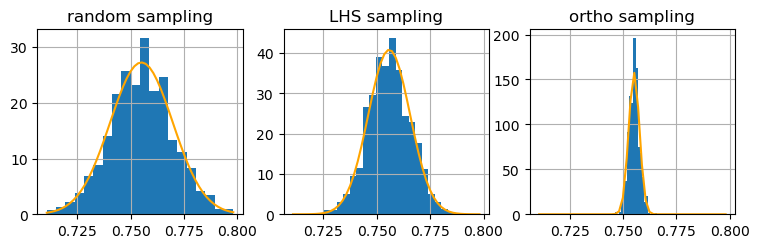

In [ ]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
num_runs = 1000
normalize = False

sampling_types = ['random', 'LHS', 'ortho']

df_area_subset = df_area[(df_area['Iterations'] == df_area['Iterations'].max()) & (df_area['Samples'] == df_area['Samples'].max())]

# fig, axs = plt.subplots(1, len(sampling_types), sharex=True, sharey=True)
fig, axs = plt.subplots(1, len(sampling_types), sharey=False)
fig.set_size_inches(9, 2.4)
# fig.suptitle(f"Estimated area distribution")

for i, sampling_type in enumerate(sampling_types):
    df_area_subset_strategy = df_area_subset[df_area_subset['Strategy'] == sampling_type]['Area']
    sample_mean = df_area_subset_strategy.mean()
    sample_var = df_area_subset_strategy.var()
    sample_std = df_area_subset_strategy.std()
    print(f"Area sample mean ({sampling_type} sampling): {sample_mean}")
    print(f"Area sample variance ({sampling_type} sampling): {sample_var}")
    print(f"Area sample standard deviation ({sampling_type} sampling): {sample_std}")

    if normalize:
        areas_normalized = (df_area_subset_strategy - sample_mean) / sample_std
    else:
        areas_normalized = df_area_subset_strategy
    areas_normalized.hist(bins=num_runs//50, ax=axs[i], density=True)

    if normalize:
        norm_x = np.linspace(-3, 3, 50)
        axs[i].plot(norm_x, stats.norm.pdf(norm_x, 0, 1), c='orange')
    else:
        norm_x = np.linspace(df_area_subset['Area'].min(), df_area_subset['Area'].max(), 50)
        axs[i].plot(norm_x, stats.norm.pdf(norm_x, sample_mean, sample_std), c='orange')
    axs[i].set_title(f"{sampling_type} sampling")
    ticks = [sample_mean-2*sample_std, sample_mean, sample_mean+2*sample_std]
    # axs[i].set_xticks(ticks, labels=['{:.{}f}'.format(t, 3) for t in ticks])

The simulation results are re-structured for the upcoming statistical tests.

In [ ]:
# Sample constructor
dict_sample = {}

for iterations in df_area['Iterations'].unique():

    for samples in df_area['Samples'].unique():


        sample_monte_carlo = df_area_subset[df_area_subset['Strategy'] == 'random']
        sample_LHS = df_area_subset[df_area_subset['Strategy'] == 'LHS']
        sample_ortho = df_area_subset[df_area_subset['Strategy'] == 'ortho']


Statistical tests that will be done (both T-test and F-Test)


$\hat{X}_{Classic Monte Carlo}$ vs. $\hat{X}_{LHS}$

$\hat{X}_{Classic Monte Carlo}$ vs. $\hat{X}_{Orthogonal Sampling}$

$\hat{X}_{Classic Monte Carlo}$ vs. $\hat{X}_{Improved Stochastic Method}$

$\hat{X}_{LHS}$ vs. $\hat{X}_{Orthogonal Sampling}$

$\hat{X}_{LHS}$ vs. $\hat{X}_{Improved Stochastic Method}$

$\hat{X}_{Orthogonal Sampling}$ vs. $\hat{X}_{Improved Stochastic Method}$


In [ ]:
def F_test_for_equality_of_variances(sample_1, sample_2):
    '''Performs an F-test for equality of variances.
    Returns the F-statistic and the p-value.
    '''
    df1 = len(sample_1) - 1
    df2 = len(sample_2) - 1
    F_statistic = np.var(sample_1, ddof=1) / np.var(sample_2, ddof=1)
    p_value = 1 - stats.f.cdf(F_statistic, df1, df2)
    return F_statistic, p_value


In [ ]:
nested_dict_t_test = {}
nested_dict_f_test = {}

for iterations in df_area['Iterations'].unique():
    nested_dict_t_test[iterations] = {}
    nested_dict_f_test[iterations] = {}
    
    for samples in df_area['Samples'].unique():
        
        # Define the samples
        sample_monte_carlo = df_area[(df_area['Strategy'] == 'random') & (df_area['Iterations'] == iterations) & (df_area['Samples'] == samples)]
        sample_LHS = df_area[(df_area['Strategy'] == 'LHS') & (df_area['Iterations'] == iterations) & (df_area['Samples'] == samples)]
        sample_ortho = df_area[(df_area['Strategy'] == 'ortho') & (df_area['Iterations'] == iterations) & (df_area['Samples'] == samples)]
        
        # Pairwise t-testing for difference in means
        t_test_monte_LHS = stats.ttest_ind(sample_monte_carlo['Error'], sample_LHS['Error'], equal_var=False)[:2]
        t_test_monte_ortho = stats.ttest_ind(sample_monte_carlo['Error'], sample_ortho['Error'], equal_var=False)[:2]
        t_test_LHS_ortho = stats.ttest_ind(sample_LHS['Error'], sample_ortho['Error'], equal_var=False)[:2]

        # Pairwise F-testing for equality of variances
        f_test_monte_LHS = F_test_for_equality_of_variances(sample_monte_carlo['Error'], sample_LHS['Error'])
        f_test_monte_ortho = F_test_for_equality_of_variances(sample_monte_carlo['Error'], sample_ortho['Error'])
        f_test_LHS_ortho = F_test_for_equality_of_variances(sample_LHS['Error'], sample_ortho['Error'])

        nested_dict_t_test[iterations][samples] = {
            'monte_LHS': {'T_stat': t_test_monte_LHS[0], 'p_value': t_test_monte_LHS[1]},
            'monte_ortho': {'T_stat': t_test_monte_ortho[0], 'p_value': t_test_monte_ortho[1]},
            'LHS_ortho': {'T_stat': t_test_LHS_ortho[0], 'p_value': t_test_LHS_ortho[1]}
        }

        nested_dict_f_test[iterations][samples] = {
            'monte_LHS': {'F_stat': f_test_monte_LHS[0], 'p_value': f_test_monte_LHS[1]},
            'monte_ortho': {'F_stat': f_test_monte_ortho[0], 'p_value': f_test_monte_ortho[1]},
            'LHS_ortho': {'F_stat': f_test_LHS_ortho[0], 'p_value': f_test_LHS_ortho[1]}
        }

In [ ]:
# Creating a dataframe at max iterations to test mean error for the T-test, for varying samplesizes.
monte_LHS_T_test_p_value = [nested_dict_t_test[1000][samples]['monte_LHS']['p_value'] for samples in df_area['Samples'].unique()]
monte_ortho_T_test_p_value = [nested_dict_t_test[1000][samples]['monte_ortho']['p_value'] for samples in df_area['Samples'].unique()]
LHS_ortho_T_test_p_value = [nested_dict_t_test[1000][samples]['LHS_ortho']['p_value'] for samples in df_area['Samples'].unique()]


monte_LHS_T_test_T_stat = [nested_dict_t_test[1000][samples]['monte_LHS']['T_stat'] for samples in df_area['Samples'].unique()]
monte_ortho_T_test_T_stat = [nested_dict_t_test[1000][samples]['monte_ortho']['T_stat'] for samples in df_area['Samples'].unique()]
LHS_ortho_T_test_T_stat = [nested_dict_t_test[1000][samples]['LHS_ortho']['T_stat'] for samples in df_area['Samples'].unique()]

matrix_p_values_T_test = np.array([monte_LHS_T_test_p_value, monte_ortho_T_test_p_value, LHS_ortho_T_test_p_value])
matrix_T_statistic_T_test = np.array([monte_LHS_T_test_T_stat, monte_ortho_T_test_T_stat, LHS_ortho_T_test_T_stat])


monte_LHS = [nested_dict_t_test[1000][samples]['monte_LHS']['T_stat'] for samples in df_area['Samples'].unique()]
monte_ortho = [nested_dict_t_test[1000][samples]['monte_ortho']['T_stat'] for samples in df_area['Samples'].unique()]
LHS_ortho = [nested_dict_t_test[1000][samples]['LHS_ortho']['T_stat'] for samples in df_area['Samples'].unique()]

matrix_p_values_T_test_samples = np.array([monte_LHS, monte_ortho, LHS_ortho]) 
matrix_T_statistic_T_test_samples = np.array([monte_LHS, monte_ortho, LHS_ortho])

booleaan_rejection_matrix_p_values_T_test_samples = matrix_p_values_T_test_samples < 0.05
booleaan_rejection_matrix_T_stats_T_test_samples = matrix_T_statistic_T_test_samples < 0.05

In [ ]:
matrix_p_values_T_test_samples

array([[-8.33262894e-01,  8.42711006e-01, -8.85519055e-01,
         1.17442543e+00,  2.87229814e-01,  6.93293880e-01,
        -2.25619630e-01,  1.05912829e+00,  2.44306687e-01,
         1.15465436e+00, -3.23673825e-01, -1.07536628e+00,
         1.24575090e+00, -1.84483215e-01,  1.32328696e+00,
        -4.48505151e-01, -1.15966348e+00, -7.13505900e-01,
         2.28980881e-01, -6.81670086e-02,  1.04405145e+00,
        -1.94828849e-01,  1.71449421e+00,  2.70289923e-01,
        -9.90314413e-01,  1.99460489e+00,  8.96091708e-01,
         1.31272783e+00, -3.78428058e-02,  6.06108572e-01,
        -2.53029882e-02,  8.43943206e-01,  1.58503677e+00,
        -2.52693931e-01,  1.57240460e-01,  1.37276440e+00,
         3.44496021e-01, -4.02959611e-01,  2.02897618e+00,
         5.71356484e-01,  1.33879892e+00,  1.33213274e+00,
        -1.23542350e-01,  3.72333004e-01,  1.41822958e+00,
         2.80163290e-01,  9.57720993e-01,  2.64035203e-01,
         1.72763049e+00,  2.51092563e+00,  1.07546553e+0

In [ ]:
booleaan_rejection_matrix_p_values_T_test_samples

array([[ True, False,  True, False, False, False,  True, False, False,
        False,  True,  True, False,  True, False,  True,  True,  True,
        False,  True, False,  True, False, False,  True, False, False,
        False,  True, False,  True, False, False,  True, False, False,
        False,  True, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False,  True],
       [ True, False, False, False,  True,  True,  True,  True, False,
         True, False,  True, False,  True, False,  True,  True,  True,
        False, False, False,  True, False,  True,  True, False, False,
        False,  True, False,  True,  True, False,  True,  True, False,
         True,  True, False, False, False, False,  True,  True, False,
        False,  True, False, False, False, False, False, False,  True,
        False,  True, Fals

In [ ]:
# Creating a dataframe at max iterations to test equallity of variance of error using the F-test, for varying samplesizes.
monte_LHS_F_test_p_value = [nested_dict_f_test[1000][samples]['monte_LHS']['p_value'] for samples in df_area['Samples'].unique()]
monte_ortho_F_test_p_value = [nested_dict_f_test[1000][samples]['monte_ortho']['p_value'] for samples in df_area['Samples'].unique()]
LHS_ortho_F_test_p_value = [nested_dict_f_test[1000][samples]['LHS_ortho']['p_value'] for samples in df_area['Samples'].unique()]

monte_LHS_F_test_F_stat = [nested_dict_f_test[1000][samples]['monte_LHS']['F_stat'] for samples in df_area['Samples'].unique()]
monte_ortho_F_test_F_stat = [nested_dict_f_test[1000][samples]['monte_ortho']['F_stat'] for samples in df_area['Samples'].unique()]
LHS_ortho_F_test_F_stat = [nested_dict_f_test[1000][samples]['LHS_ortho']['F_stat'] for samples in df_area['Samples'].unique()]

matrix_p_values_F_test_samples = np.array([monte_LHS_F_test_p_value, monte_ortho_F_test_p_value, LHS_ortho_F_test_p_value])
matrix_F_statistic_F_test_samples  = np.array([monte_LHS_F_test_F_stat, monte_ortho_F_test_F_stat, LHS_ortho_F_test_F_stat])

booleaan_rejection_matrix_p_values_F_test_samples = matrix_p_values_F_test_samples < 0.05
booleaan_rejection_matrix_F_stats_F_test_samples = matrix_F_statistic_F_test_samples < 0.05


In [ ]:
def visualize_test_results_samples(matrix, title):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(16, 3)
    boundaries = [0, 0.5, 1]
    cmap = mpl.colors.ListedColormap(['red', 'green'])
    norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    ax.imshow(matrix, cmap=cmap, norm=norm)
    ax.set_xticks(range(len(df_area['Samples'].unique().astype(int))))
    ax.set_xticklabels(df_area['Samples'].unique().astype(int))

    # rotate labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_yticks(range(3))
    ax.set_yticklabels([
        "monte vs. LHS",
        "monte vs. ortho",
        "LHS vs. ortho",
        ])
    plt.xlabel("sample size")
    plt.ylabel("tested pair")
    plt.title(title)
    plt.show()

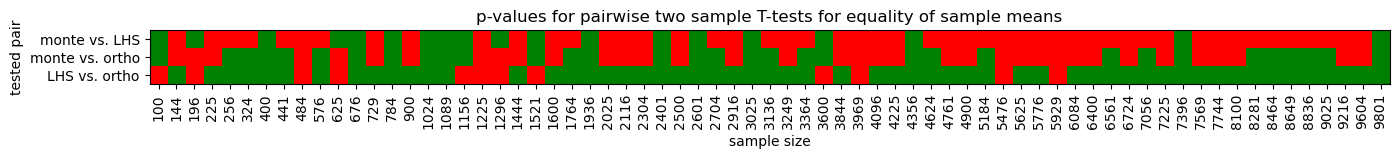

In [ ]:
visualize_test_results_samples(booleaan_rejection_matrix_p_values_T_test_samples, "p-values for pairwise two sample T-tests for equality of sample means")

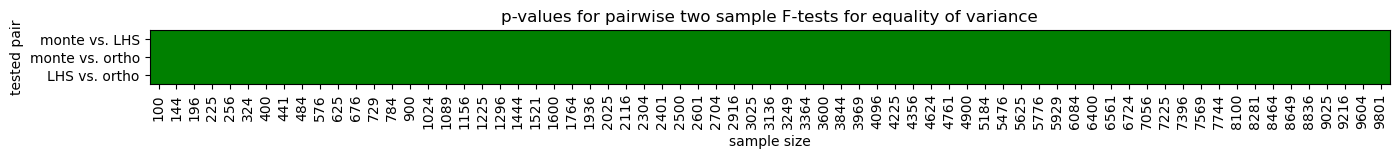

In [ ]:
visualize_test_results_samples(booleaan_rejection_matrix_p_values_F_test_samples, "p-values for pairwise two sample F-tests for equality of variance")

In [ ]:
# Creating a dataframe at max sample size to test equallity of variance of error using the F-test, for varying iterations.
monte_LHS_T_test_p_value = [nested_dict_f_test[iterations][9801]['monte_LHS']['p_value'] for iterations in df_area['Iterations'].unique()]
monte_ortho_T_test_p_value = [nested_dict_f_test[iterations][9801]['monte_ortho']['p_value'] for iterations in df_area['Iterations'].unique()]
LHS_ortho_T_test_p_value = [nested_dict_f_test[iterations][9801]['LHS_ortho']['p_value'] for iterations in df_area['Iterations'].unique()]

monte_LHS_T_test_T_stat = [nested_dict_f_test[iterations][9801]['monte_LHS']['F_stat'] for iterations in df_area['Iterations'].unique()]
monte_ortho_T_test_T_stat = [nested_dict_f_test[iterations][9801]['monte_ortho']['F_stat'] for iterations in df_area['Iterations'].unique()]
LHS_ortho_T_test_T_stat = [nested_dict_f_test[iterations][9801]['LHS_ortho']['F_stat'] for iterations in df_area['Iterations'].unique()]

matrix_p_values_T_test_iterations = np.array([monte_LHS_T_test_p_value, monte_ortho_T_test_p_value, LHS_ortho_T_test_p_value])
matrix_T_statistic_T_test_iterations = np.array([monte_LHS_T_test_T_stat, monte_ortho_T_test_T_stat, LHS_ortho_T_test_T_stat])

booleaan_rejection_matrix_p_values_T_test_iterations = matrix_p_values_T_test_iterations < 0.05
booleaan_rejection_matrix_T_stats_T_test_iterations = matrix_T_statistic_T_test_iterations < 0.05

In [ ]:
# Creating a dataframe at max sample size to test equallity of variance of error using the F-test, for varying iterations.
monte_LHS_F_test_p_value = [nested_dict_f_test[iterations][9801]['monte_LHS']['p_value'] for iterations in df_area['Iterations'].unique()]
monte_ortho_F_test_p_value = [nested_dict_f_test[iterations][9801]['monte_ortho']['p_value'] for iterations in df_area['Iterations'].unique()]
LHS_ortho_F_test_p_value = [nested_dict_f_test[iterations][9801]['LHS_ortho']['p_value'] for iterations in df_area['Iterations'].unique()]

monte_LHS_F_test_F_stat = [nested_dict_f_test[iterations][9801]['monte_LHS']['F_stat'] for iterations in df_area['Iterations'].unique()]
monte_ortho_F_test_F_stat = [nested_dict_f_test[iterations][9801]['monte_ortho']['F_stat'] for iterations in df_area['Iterations'].unique()]
LHS_ortho_F_test_F_stat = [nested_dict_f_test[iterations][9801]['LHS_ortho']['F_stat'] for iterations in df_area['Iterations'].unique()]

matrix_p_values_F_test_iterations = np.array([monte_LHS_T_test_p_value, monte_ortho_T_test_p_value, LHS_ortho_T_test_p_value])
matrix_F_statistic_F_test_iterations = np.array([monte_LHS_T_test_T_stat, monte_ortho_T_test_T_stat, LHS_ortho_T_test_T_stat])

booleaan_rejection_matrix_p_values_F_test_iterations = matrix_p_values_F_test_iterations < 0.05
booleaan_rejection_matrix_T_stats_F_test_iterations = matrix_F_statistic_F_test_iterations < 0.05

In [ ]:
def visualize_test_results_itartions(matrix, title):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(16, 3)
    boundaries = [0, 0.5, 1]
    cmap = mpl.colors.ListedColormap(['red', 'green'])
    norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    ax.imshow(matrix, cmap=cmap, norm=norm)
    ax.set_xticks(range(len(df_area['Iterations'].unique().astype(int)))
    ax.set_xticklabels(df_area['Iterations'].unique().astype(int))

    # rotate labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_yticks(range(3))
    ax.set_yticklabels([
        "monte vs. LHS",
        "monte vs. ortho",
        "LHS vs. ortho",
        ])
    plt.xlabel("iterations")
    plt.ylabel("tested pair")
    plt.title(title)
    plt.show()

In [ ]:
booleaan_rejection_matrix_p_values_F_test_iterations

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]])

For the T-test

Green indicates we reject h0, using a two sided T-test H0 of equality of sample means is rejected at the alpha = 0.05 level using a two sided pairwise two sample T-test in favor of HA which states that the sample means are unequal. Red indicated we do not reject h0 which states that the sample means are equal.


From the results, we can see that the mean error is statistically significantly different between some pairs, depending on s.



For the F-test


Green indicates we reject h0, using a two sided F-test H0 of equality of sample variances is rejected at the alpha = 0.05 level, in favor of HA which states that variances are unequal. Red indicated we do not reject h0 which states that the sample variances are equal.


From the results, we can see that the variance of the error is different for each value of s in line with visual results


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (12).

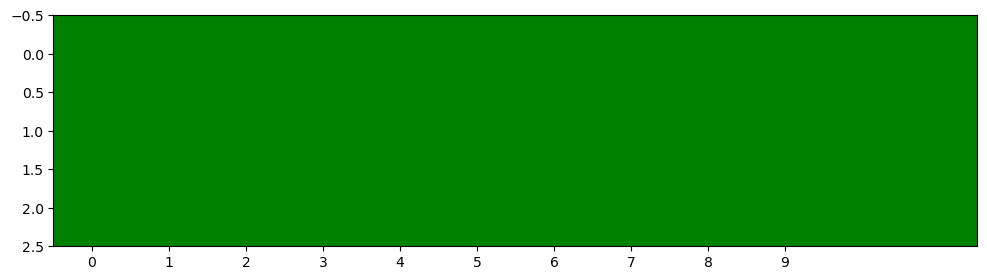

In [ ]:
visualize_test_results_itartions(booleaan_rejection_matrix_p_values_F_test_iterations, "p-values for pairwise two sample T-tests for equality of means")

In [ ]:
visualize_test_results_itartions(booleaan_rejection_matrix_p_values_F_test_iterations, "p-values for pairwise two sample F-tests for equality of variance")

## Adaptive Grid Sampling

An enhanced sampling method is constructed which implements two stages of LHS sampling:
- first, a course LHS sampling is performed within the cells a predefined grid, evalulating the Mandelbrot set for two different iteration counts. The error between the average escape times at these two iteration counts forms a score which is used for ranking the grid cells.
- second, a fine-grain LHS sampling is performed in each cell grid, the number of samples depending on the ranking of the grid cell.

In [18]:
def create_grid_cells(xmin, xmax, ymin, ymax, rows, cols):
    '''Creates an array of rectangular intervals inside an input region.
    Outputs the intervals as dictionaries of min and max values along each coodinate axis.
    '''
    
    grid_cells = []

    # Calculate the step size for rows and columns
    row_step = (ymax - ymin) / rows
    col_step = (xmax - xmin) / cols

    # Loop through rows and columns to create grid cells
    for i in range(rows):
        for j in range(cols):
            # Calculate vertices of the current grid cell
            cell_xmin = xmin + j * col_step
            cell_xmax = cell_xmin + col_step
            cell_ymin = ymin + i * row_step
            cell_ymax = cell_ymin + row_step

            # Store vertices in a dictionary
            grid_cell = {
                'xmin': cell_xmin,
                'xmax': cell_xmax,
                'ymin': cell_ymin,
                'ymax': cell_ymax
            }

            # Add the grid cell to the list
            grid_cells.append(grid_cell)

    return grid_cells

# Example usage
xmin, xmax, ymin, ymax = 1, 5, 2, 6
rows, cols = 2, 2
grid = create_grid_cells(xmin, xmax, ymin, ymax, rows, cols)

# Print the result
for i, subgrid in enumerate(grid, start=1):
    print(f"Subgrid {i}: {subgrid}")

Subgrid 1: {'xmin': 1.0, 'xmax': 3.0, 'ymin': 2.0, 'ymax': 4.0}
Subgrid 2: {'xmin': 3.0, 'xmax': 5.0, 'ymin': 2.0, 'ymax': 4.0}
Subgrid 3: {'xmin': 1.0, 'xmax': 3.0, 'ymin': 4.0, 'ymax': 6.0}
Subgrid 4: {'xmin': 3.0, 'xmax': 5.0, 'ymin': 4.0, 'ymax': 6.0}


In [546]:
def create_and_rank_grids_area(xmin, xmax, ymin, ymax, rows, cols, iteration_range, samples_per_grid):
    '''Subdivides the input region into a grid of size rows x cols,
    Performs quick low-sample evaluation of the Mandelbrot set in each sub-interval
    of the grid and captures the state at two iteration moments.
    The difference in escape time between these two moments determines the score of a cell.
    The function outputs the sub-intervals and the cells.
    '''

    subgrids = create_grid_cells(xmin, xmax, ymin, ymax, rows, cols)
    grid_scores = np.zeros((len(subgrids),len(iteration_range)))
    subgrid_samples = []
    e = os.sys.float_info.epsilon
    
    for s, subgrid in enumerate(subgrids):
        xmin, xmax, ymin, ymax = subgrid.values()
        pt_samples = latin_hypercube_sampling(xmin, xmax, ymin, ymax, samples_per_grid)
        #pt_samples = orthogonal_sampling(xmin, xmax, ymin, ymax, samples_per_grid, 10)
        complex_samples = coords_to_complex(pt_samples)
        subgrid_samples.append(complex_samples)
        for i, iter in enumerate(iteration_range):
            mandelbrot_iters = vectorized_mandelbrot(complex_samples, iter)
            grid_scores[s,i] = (np.mean(mandelbrot_iters) / (max(mandelbrot_iters)+e))
                  
    return subgrids, grid_scores, subgrid_samples

In [547]:
def distribute_sample_sizes(subgrids, grid_scores, subgrid_samples, total_samples, min_samples, max_samples):
    '''Function to assign a number of samples across the subgrids
    according to their rank with a cap on min and max samples per interval'''

    # Combine the list of objects with the corresponding scores
    combined_data = list(zip(subgrids, grid_scores, subgrid_samples))

    e = os.sys.float_info.epsilon

    # Sort combined data based on scores in descending order
    sorted_data = sorted(combined_data, key=lambda x: x[1], reverse=True)

    # Initialize variables
    samples_array = []
    total_samples_allocated = 0

    # Calculate the total number of samples to allocate
    total_samples_to_allocate = min(total_samples - len(subgrids) * min_samples , len(subgrids) * max_samples - len(subgrids) * min_samples)

    score_rem = sum(grid_scores)


    # Iterate through sorted data and allocate samples
    for subgrid, score, subgrid_sample in sorted_data:
        if score != 0:
            allocated_samples = min_samples +  min(max_samples, round(total_samples_to_allocate * ((score) / (score_rem))))
        else:
            allocated_samples = min_samples

        score_rem = score_rem - score

        samples_array.append(allocated_samples)

        # Update total samples allocated
        total_samples_allocated += allocated_samples
        total_samples_to_allocate = total_samples_to_allocate - allocated_samples + min_samples
    
    sorted_subgrids = [item[0] for item in sorted_data]
    sorted_subgrid_samples = [item[2] for item in sorted_data]

    if len(sorted_subgrids) != len(samples_array):
        return None

    return sorted_subgrids, samples_array, sorted_subgrid_samples

# Example usage:
objects = [
    {'name': 'Object1'},
    {'name': 'Object2'},
    {'name': 'Object3'},
    # Add more objects as needed
]

scores = [0, 520, 70]  # Scores corresponding to the objects
samples = [[3,5,6],[1,2,3],[1,4,5]]

n = 1000  # Total number of samples to allocate
min_samples_per_object = 10  # Minimum samples per object
max_samples_per_object = 400  # Maximum samples per object

result = distribute_sample_sizes(objects, scores, samples, n, min_samples_per_object, max_samples_per_object)

print(result)


([{'name': 'Object2'}, {'name': 'Object3'}, {'name': 'Object1'}], [410, 410, 10], [[1, 2, 3], [1, 4, 5], [3, 5, 6]])


In [548]:
def sampling_by_grid_ranks_final(xmin, xmax, ymin, ymax, rows, cols, iteration_range, max_iter, fraction_presamples, total_samples, half = False):
    samples_per_grid = int((total_samples * fraction_presamples)/(rows*cols))
    presample_size_total = rows * cols * samples_per_grid
    subgrids, grid_scores, subgrid_samples = create_and_rank_grids_area(xmin, xmax, ymin, ymax, rows, cols, iteration_range, samples_per_grid)
    gradient_changes = abs(grid_scores[:,0] - grid_scores[:,1])
    samples_to_divide = total_samples - presample_size_total
    sorted_subgrids, samples_array, subgrid_samples = distribute_sample_sizes(subgrids, gradient_changes, subgrid_samples, samples_to_divide, 0, int(samples_to_divide * 0.1))
    area = 0
    samples = 0
    for i, subgrid in enumerate(sorted_subgrids):
        xmin, xmax, ymin, ymax = subgrid.values()
        # pt_samples = orthogonal_sampling(xmin, xmax, ymin, ymax, samples_array[i], 10)
        if samples_array[i] != 0:
            pt_samples = latin_hypercube_sampling(xmin, xmax, ymin, ymax, samples_array[i])
            complex_samples = coords_to_complex(pt_samples)
            complex_samples = np.concatenate((complex_samples,subgrid_samples[i]))
        else:
            complex_samples = subgrid_samples[i]
        mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
        area += (np.sum(np.where(mandelbrot_iters == max_iter, 1, 0)) / len(mandelbrot_iters)) * ((ymax-ymin)*(xmax-xmin))
        samples += len(complex_samples)
    if half == True:
        return area*2
    else:
        return area

3000 pre-samples
100 subgrids
1.5101844752752236
20000 secondary samples


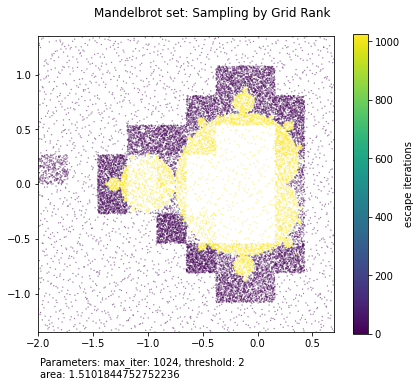

In [551]:
max_iter = 1024
e = os.sys.float_info.epsilon
# Pre-sampling parameters
presample_iters = [30, 500]
rows = 10
cols = 10
samples_per_grid = 30
presample_size_total = rows * cols * samples_per_grid
print(f"{presample_size_total} pre-samples")

subgrids, grid_scores, subgrid_samples = create_and_rank_grids_area(-2.0, 0.7, -1.35, 1.35, rows, cols, presample_iters, samples_per_grid)
errors = abs((grid_scores[:,0] - grid_scores[:,1]))
print(f"{len(subgrids)} subgrids")

# Secondary sampling
sample_size_total = 20000
sorted_subgrids, samples_array, subgrid_samples = distribute_sample_sizes(subgrids, errors, subgrid_samples, sample_size_total-presample_size_total, 1, 4000)
area = 0
samples_count = 0
samples_total = np.array([])
iters_total = np.array([])
for i, subgrid in enumerate(sorted_subgrids):
    xmin, xmax, ymin, ymax = subgrid.values()
    pt_samples = latin_hypercube_sampling(xmin, xmax, ymin, ymax, samples_array[i])
    complex_samples = coords_to_complex(pt_samples)
    complex_samples = np.concatenate((complex_samples,subgrid_samples[i]))
    mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
    area += (np.sum(np.where(mandelbrot_iters == max_iter, 1, 0)) / len(mandelbrot_iters)) * ((ymax-ymin)*(xmax-xmin))
    samples_count = samples_count + len(complex_samples)
    samples_total = np.concatenate((samples_total, complex_samples))
    iters_total = np.concatenate((iters_total, mandelbrot_iters))
        
print(area)
print(f"{samples_count} secondary samples")

plot_samples_mandelbrot(-2.0, 0.7, -1.35, 1.35, samples_total, iters_total, half=False, ax=None, sampling_method='Sampling by Grid Rank', max_iter=iterations, threshold=2, area=area)


In [553]:
num_runs = 10
Areas = []
for i in range(num_runs):
    Areas.append(sampling_by_grid_ranks_final(-2.0, 0.7, 0, 1.35, 10, 10, [30,512], 1024, 0.3, 10000, half = True))
print(np.mean(np.array(Areas)))
print(np.std(np.array(Areas)))

1.5086214880213349
0.005095001595192348


(100, 100)
(10000,)


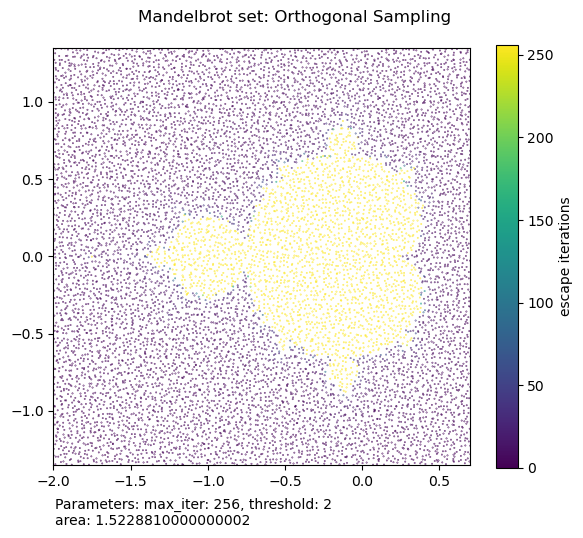

In [71]:
half = False

if half: xmin, xmax, ymin, ymax = -2.0, 0.7, 0, 1.35
else: xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 10000
max_iter = 256

def orthogonal_presampling(xmin, xmax, ymin, ymax, sample_size):
    '''Uses orthogonal sampling to populate an interval, then
    groups the sample points in larger squares of size N/N_sub and outputs the
    grouped samples as complex numbers and the grid of larger squares as
    a dictionary of min/max values along each coorinate.
    '''

    n_sub_intervals = get_median_divisor(np.sqrt(sample_size))
    n_super_intervals = int(np.sqrt(sample_size) // n_sub_intervals)

    # Get 2D intervals of coarse grid
    subgrids = create_grid_cells(xmin, xmax, ymin, ymax, n_super_intervals, n_super_intervals)

    # Perform orthogonal sampling
    pt_samples = orthogonal_sampling(xmin, xmax, ymin, ymax, sample_size, n_sub_intervals)
    complex_samples = coords_to_complex(pt_samples)

    # Reassign samples to coarse grid
    complex_samples_subgrids = np.empty((len(subgrids), n_sub_intervals*n_sub_intervals), dtype='cfloat')
    for i, subgrid in enumerate(subgrids):
        cell_samples = []
        for cs in complex_samples:
            if subgrid['xmin'] < np.real(cs) <= subgrid['xmax'] and subgrid['ymin'] <= np.imag(cs) < subgrid['ymax']:
                cell_samples.append(cs)
        complex_samples_subgrids[i] = np.array(cell_samples, dtype='cfloat')

    return complex_samples_subgrids, subgrids


complex_samples_grid = orthogonal_presampling(xmin, xmax, ymin, ymax, sample_size)
print(complex_samples_grid.shape)
complex_samples = complex_samples_grid.flatten()
print(complex_samples.shape)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, max_iter, half=half)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters, half=half,
                        sampling_method='Orthogonal Sampling', max_iter=max_iter, threshold=2, sub_lvl=10, area=area)

## Statistical testing

Statistical testing of the simulation will allow to to quantify out confidence in how much different method differ.

This consists of two phases:

Comparing each method (Classic Monte Carlo, LHS, Orthogonal, Improved stochastic (yet to be devised)) against our estimated ground truth, $A_{m*}$

To do so we perform a one sample T-test between the area of $A_{m*}$, which we call $\mu_{0}$ and the expected value of the area obtained from each of our methods $\hat{X}$.
Our obtained value of the area from $A_{m*}$, $X_{0}$ does not vary accross runs (it only depends on the coarseness of the grid and not on the spread of the samples). 
However, the estimate of the area using one of our sampling methods $\hat{X}$ does vary, meaning we need to take into account our sample standard deviation $S_{\bar{x}}$. This makes a one sample t-test the approriate choice. This results in the following test statistic:

$T=\frac{X-\mu_0}{s_{\bar{x}}}$

We check to see if the T-statistic is outside a critcal region of our choosing (for example, for a two sided test |T. Actual| > 1.96 for $\alpha = 0.05$).
We also need to test if the distribution obtained from our simulations conform to the assumptions of the T-Test (i.i.d. random sample, etc.).


We first perform 4 pairwise tests:

$\hat{X}_{Classic Monte Carlo}$ vs. $\mu_{0}$

$\hat{X}_{LHS}$ vs. $\mu_{0}$

$\hat{X}_{Orthogonal Sampling}$ vs. $\mu_{0}$

$\hat{X}_{Improved Stochastic Method}$ vs. $\mu_{0}$


As soon as we have a statistical estimate of the difference between the area estimated by out methods, we test the difference between methods using a two sample test Welch test (as the sample variances are known but the population variances are not. For this we use the following test statistic:


$T_{Welch} = \frac{\bar{X}-\bar{Y}}{\sqrt{\frac{S_x^2}{n_x}+\frac{S_y^2}{n_y}}}$


$\hat{X}_{Classic Monte Carlo}$ vs. $\hat{X}_{LHS}$

$\hat{X}_{Classic Monte Carlo}$ vs. $\hat{X}_{Orthogonal Sampling}$

$\hat{X}_{Classic Monte Carlo}$ vs. $\hat{X}_{Improved Stochastic Method}$

$\hat{X}_{LHS}$ vs. $\hat{X}_{Orthogonal Sampling}$

$\hat{X}_{LHS}$ vs. $\hat{X}_{Improved Stochastic Method}$

$\hat{X}_{Orthogonal Sampling}$ vs. $\hat{X}_{Improved Stochastic Method}$







In [ ]:


# t-test:https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html
# one sample t_test

scipy.stats.ttest_1samp(a, popmean, axis=0, nan_policy='propagate', alternative='two-sided', *, keepdims=False)


# welch's t-test: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
# two sample t_test, put equal variances at False
scipy.stats.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0, *, keepdims=False)

SyntaxError: incomplete input (2506481983.py, line 7)

In [ ]:
print(np.mean(np.array(Samples)))


9983.0


In [ ]:
array = np.array([[1,2],[1,2]])
df_array = pd.DataFrame(array, columns=['a', 'b'])
df_array.to_csv("test_array")